In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset)

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]]), 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
  

In [5]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [6]:
# Normalise the target data (this will make clearer training curves)
targets = (targets-targets.mean(axis=0))/targets.std()


In [7]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data,test_data,train_targets,test_targets = train_test_split(data,targets,test_size=0.1)


#### Train a feedforward neural network model

In [8]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128,activation = 'relu',input_shape =(train_data.shape[1],)),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(1)
    ])
    return model
model = get_model()

In [9]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [10]:
# Compile the model

model.compile(optimizer ="adam",loss = "mse",metric=["mae"])

In [11]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False)

In [12]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 1.0421


0.9790521780649821

#### Plot the learning curves

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

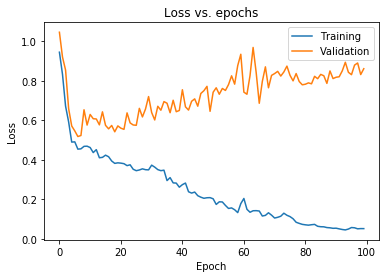

In [14]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [17]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-3,0.3)

In [18]:
# Compile the model

model.compile(optimizer ="adam",loss = "mse",metric=["mae"])

In [19]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False)

In [20]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose=2)

45/1 - 0s - loss: 0.9035


0.7397039651870727

#### Plot the learning curves

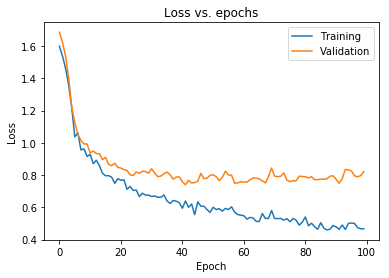

In [21]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [24]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training....")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    
    def on_train_end(self, logs=None):
        print("Finished training!")
# class TestCallback(Callback):
#     def on_test_begin（self,logs = None):
#         print("Starting testing....")
#     def on_test_batch_begin（self,batch,logs = None):
#         print(f"Testing: Starting batch {batch}")
#     def on_test_batch_end（self,batch,logs = None):
#         print(f"Testing: Finished batch {batch}") 
#     def on_test_end（self,logs = None):
#         print("Finished testing!")   
# class PredictionCallback(Callback):
#     def on_prediction_begin（self,logs = None):
#         print("Starting predcting....")
#     def on_prediction_batch_begin（self,batch,logs = None):
#         print(f"Predicting: Starting batch {batch}")
#     def on_prediction_batch_end（self,batch,logs = None):
#         print(f"Predicting: Finished batch {batch}") 
#     def on_prediction_end（self,logs = None):
#         print("Finished predcting!")   

In [25]:
# Re-build the model

model = get_regularised_model(1e-5,0.3)

In [26]:
# Compile the model

model.compile(optimizer ="adam",loss = "mse")

#### Train the model with the callback

In [27]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False,callbacks=[TrainCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Training: Finished batch 4
Training: Starting batch 5
Training: Finished batch 5
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Training: Finished batch 4
Training: Starting batch 5
Training: Finished batch 5
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Tr

Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Training: Finished batch 4
Training: Starting batch 5
Training: Finished batch 5
Finished epoch 23
Starting epoch 24
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Training: Finished batch 4
Training: Starting batch 5
Training: Finished batch 5
Finished epoch 24
Starting epoch 25
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Starting batch 4
Training: Finished batch 4
Training: Starting batch 5
Training: Finished batch 5
Finished epoch 25
Starting epoch 26
T

KeyboardInterrupt: 

In [ ]:
# Evaluate the model

model.evaluate(test_data,test_targets,verbose=False,callbacks=TestCallback())

In [ ]:
# Make predictions with the model

model.predict(test_data,verbose = False,callbacks=[PredictionCallback()])

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer ="adam",loss = "mse")
unregularised_model.compile(optimizer ="adam",loss = "mse")
unreg_history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False,callbacks =[tf.keras.callbacks.Earlystopping(patience=2)])

In [ ]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data,test_targets,verbose=2)

In [ ]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-3,0.3)
regularised_model.compile(optimizer ="adam",loss = "mse")
reg_history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False,callbacks =[tf.keras.callbacks.Earlystopping(patience=2)])


In [ ]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data,test_targets,verbose=2)

#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()